In [46]:
import numpy as np
import pandas as pd

#Technical indicators
import talib as ta

#plotting
import matplotlib.pyplot as plt

#ML
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#fetching
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


Now that all necessary libraries are imported, we import the data itself

In [77]:
df = pdr.get_data_yahoo('AMZN','2000-01-01','2020-01-01')
df = df.dropna()
df = df.iloc[:,:4]
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2000-01-03,81.5000,89.5625,79.046875,89.3750
2000-01-04,85.3750,91.5000,81.750000,81.9375
2000-01-05,70.5000,75.1250,68.000000,69.7500
2000-01-06,71.3125,72.6875,64.000000,65.5625
2000-01-07,67.0000,70.5000,66.187500,69.5625


We now define our independent variables (predictors):

In [78]:
df['S_10'] = df['Close'].rolling(window=10).mean() #10D moving average
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10']) #correlation
df['RSI'] = ta.RSI(np.array(df['Close']),timeperiod=10)
df['Open-Close']=df['Open'] - df['Close'].shift(1) #open-close
df['Open-Open']=df['Open']-df['Open'].shift(1) #open-open
df = df.dropna()
X = df.iloc[:,:9]

We now define our binary target (dependent) variable:

In [79]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1) #binary output

We now split the dataset into training and testing components

In [80]:
split = int(0.8*len(df))
X_train, X_test,y_train,y_test = X[:split],X[split:],y[:split],y[split:]

Now we instantiate the logistic regrression function and apply the model fit

In [81]:
model = LogisticRegression()
model = model.fit(X_train,y_train)
coef = pd.DataFrame(zip(X.columns,np.transpose(model.coef_)))
coef.columns = {'Variable','Coefficient'}
coef
#coef = coef.rename(columns={'Variable','Coefficient'}) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Variable,Coefficient
0,Open,[-0.05385974993293821]
1,High,[0.05467383331427153]
2,Low,[0.08661135843909919]
3,Close,[-0.09691914550885314]
4,S_10,[0.01015172919575072]
5,Corr,[0.038822285697517264]
6,RSI,[-0.0012081847097257408]
7,Open-Close,[0.032034663897824674]
8,Open-Open,[-0.011897923868012212]


The class probabilities are then calculated and class lebls are predicted

In [82]:
prob = model.predict_proba(X_test)
prob
predicted = model.predict(X_test)
predicted

array([ 1,  1, -1, ...,  1,  1,  1])

The model must now be evaluated using multiple methods. We start with a confusion matrix

In [83]:
conf_matrix = metrics.confusion_matrix(y_test,predicted)
print(conf_matrix)
print("Accuracy = ",metrics.accuracy_score(y_test, predicted)*100)

[[137 306]
 [179 381]]
Accuracy =  51.64506480558325


We can also simply use a classification model

In [86]:
print(metrics.classification_report(y_test,predicted))
print(model.score(X_test,y_test)*100)

              precision    recall  f1-score   support

          -1       0.43      0.31      0.36       443
           1       0.55      0.68      0.61       560

    accuracy                           0.52      1003
   macro avg       0.49      0.49      0.49      1003
weighted avg       0.50      0.52      0.50      1003

51.64506480558325


We can now establish a strategy via our model's prediction to buy or sell using our model, and calculate the cumulative returns of the test dataset compared to the data

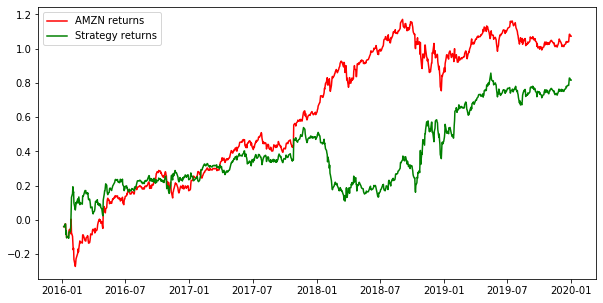

In [87]:
#Returns defined as log(closing_price/closing_price_yesterday)
df['Predicted'] = model.predict(X)
df['AMZN_returns'] = np.log(df['Close']/df['Close'].shift(1))
cumulative_AMZN_returns = np.cumsum(df[split:]['AMZN_returns'])

df['Strategy_returns'] = df['AMZN_returns']*df['Predicted'].shift(1)
cumulative_strategy_returns = np.cumsum(df[split:]['Strategy_returns'])

plt.figure(figsize=(10,5))
plt.plot(cumulative_AMZN_returns, color = 'r',label='AMZN returns')
plt.plot(cumulative_strategy_returns,color ='g',label = 'Strategy returns')
plt.legend()
plt.show()